In [20]:
# DataFrame
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from tqdm import tqdm_notebook, tnrange

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM,Input
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping , CSVLogger
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import LSTM, Dense, Embedding, Bidirectional,GlobalMaxPool1D, Lambda
from keras.layers import TimeDistributed
from keras.layers import *
from keras.optimizers import Adam,Nadam

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

#spacy
import wordninja
from nltk.tokenize import TweetTokenizer
stop_words = set(stopwords.words('english'))
tknzr = TweetTokenizer()
# import spaCy's language model
import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
tokenizer = nlp.Defaults.create_tokenizer(nlp)

# import tensorflow_hub as hub
# import tensorflow as tf
# elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

/Users/subir/pythonenv/default/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
train=pd.read_csv('./data/train_E6oV3lV.csv')
test=pd.read_csv('./data/test_tweets_anuFYb8.csv')

In [3]:
train.head()
train=train.sample(frac=1)

In [4]:
train.label.value_counts()

0    29720
1    2242 
Name: label, dtype: int64

In [5]:
combi = train.append(test, ignore_index=True,sort=False)

In [6]:
# remove special characters, numbers, punctuations
import contractions
combi['tidy_tweet'] = combi['tweet'].apply(
    lambda x: [contractions.fix(word) for word in x.split()])

combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join(x))
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("@user", "")
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z0-9#]", " ")
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace('#', 'hashtag ')


In [7]:
combi.head()

,id,label,tweet,tidy_tweet
0,27761,0.0,i just left @user and i miss her already.,i just left and i miss her already
1,18490,0.0,best 10 minutes my whole week ðð,best 10 minutes my whole week
2,29908,0.0,#men#shoes #instatags4likes #vscolove #vscogood #vscoturkey #istanbul #albumdenyansiyanlar #allshotsturkey â¦,hashtag menhashtag shoes hashtag instatags4likes hashtag vscolove hashtag vscogood hashtag vscoturkey hashtag istanbul hashtag albumdenyansiyanlar hashtag allshotsturkey
3,20362,1.0,:@ 2nites #church service look @user back of ur bible 4maps where biblical events took place. jesus &amp; his disciples r ppl of color. ð±,2nites hashtag church service look back of ur bible 4maps where biblical events took place jesus amp his disciples r ppl of color
4,23386,0.0,"#bible #quote of the #day ,, #sunday ð #bibleverse #brave !",hashtag bible hashtag quote of the hashtag day hashtag sunday hashtag bibleverse hashtag brave


In [8]:
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x: tknzr.tokenize(x))
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x: [word for word in x if word not in stop_words])

In [9]:
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x: [wordninja.split(word) for word in x if word not in 'hashtag'])

In [10]:
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x:[item for sublist in x for item in sublist] )

In [11]:
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x:' '.join(x))

In [12]:
combi.head(10)

,id,label,tweet,tidy_tweet
0,27761,0.0,i just left @user and i miss her already.,left miss already
1,18490,0.0,best 10 minutes my whole week ðð,best 10 minutes whole week
2,29908,0.0,#men#shoes #instatags4likes #vscolove #vscogood #vscoturkey #istanbul #albumdenyansiyanlar #allshotsturkey â¦,men hash tag shoes insta tags 4 likes vs co love vs co good vs co turkey istanbul album deny an si yan lar all shots turkey
3,20362,1.0,:@ 2nites #church service look @user back of ur bible 4maps where biblical events took place. jesus &amp; his disciples r ppl of color. ð±,2 nites church service look back ur bible 4 maps biblical events took place jesus amp disciples r ppl color
4,23386,0.0,"#bible #quote of the #day ,, #sunday ð #bibleverse #brave !",bible quote day sunday bibleverse brave
5,17494,0.0,make custom soundtrack for your #promotional #marketing video with 4 music #loops with relaxed acoustic feel,make custom soundtrack promotional marketing video 4 music loops relaxed acoustic feel
6,26041,1.0,the inter-terrestrial #scifi #sciencefiction on #kindleunlimited #99cents in #january #2017 #kindle,inter terrestrial scifi science fiction kindle unlimited 99 cents january 2017 kindle
7,22244,0.0,happy bihday to me. bless god!! #grateful #loved #blessed,happy bih day bless god grateful loved blessed
8,27055,1.0,scientists are against ! but only if the child is less than 18 months old...,scientists child less 18 months old
9,23672,0.0,singapore city gallery #riclswtravelbook #bearlovestravel #trip #travel #singapore â¦,singapore city gallery ric lsw travel book bear loves travel trip travel singapore


In [13]:
%%time
# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output
combi.tidy_tweet = lemmatization(combi.tidy_tweet)

CPU times: user 1min 43s, sys: 1.24 s, total: 1min 45s
Wall time: 1min 52s


In [14]:
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x : [word for word in x.split() if len(word)>1])

/Users/subir/pythonenv/default/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


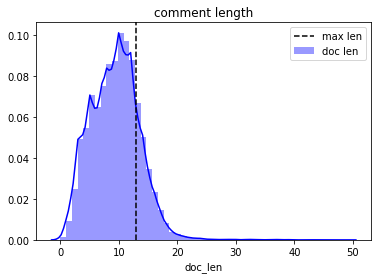

In [15]:
import seaborn as sns
combi['doc_len'] = combi['tidy_tweet'].apply(lambda words: len(words))
max_seq_len = np.round(combi['doc_len'].mean() + combi['doc_len'].std()).astype(int)
sns.distplot(combi['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [16]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join(x))

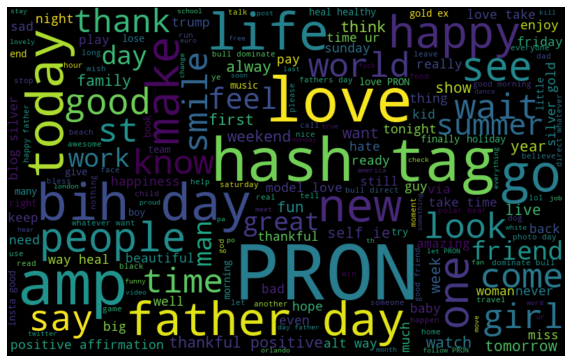

In [17]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

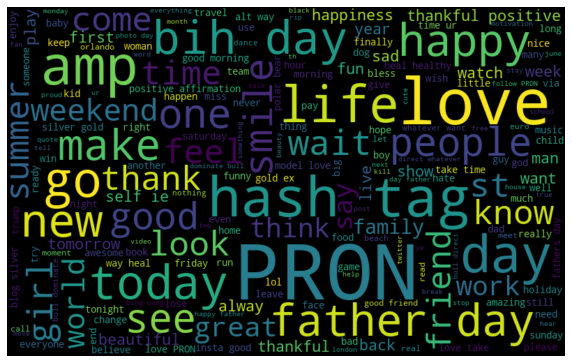

In [18]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

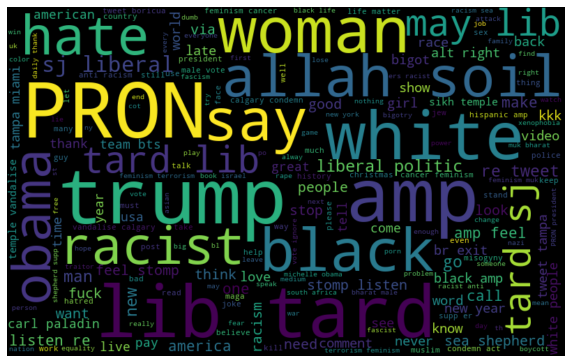

In [19]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [21]:
# WORD2VEC
from gensim.models import FastText
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 1

f2t_model = FastText(size=W2V_SIZE,
                     window=W2V_WINDOW,
                     min_count=W2V_MIN_COUNT,
                     workers=4, iter=1000)

In [22]:
%%time
documents = [_text.split() for _text in combi.tidy_tweet] 

CPU times: user 229 ms, sys: 412 ms, total: 642 ms
Wall time: 832 ms


In [23]:
%%time
f2t_model.build_vocab(documents)

CPU times: user 22.7 s, sys: 17.8 s, total: 40.6 s
Wall time: 1min 9s


In [24]:
%%time
words = f2t_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)
f2t_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

Vocab size 22799
CPU times: user 4min 46s, sys: 2.84 s, total: 4min 49s
Wall time: 1min 25s


In [25]:
embed_dim = 300 # how big is each word vector
max_features = vocab_size # how many unique words to use (i.e num rows in embedding vector)
max_seq_len = max_seq_len # max number of words in a question to use

In [26]:
df_train=combi[:len(train)]
df_test=combi[len(train):]

In [27]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(combi.tidy_tweet)
word_index = tokenizer.word_index
word_seq_train = tokenizer.texts_to_sequences(df_train['tidy_tweet'])
word_seq_test = tokenizer.texts_to_sequences(df_test['tidy_tweet'])
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = pad_sequences(word_seq_test, maxlen=max_seq_len)

dictionary size:  22797


In [28]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())
y_train = encoder.transform(df_train.label.tolist())
y_train = y_train.reshape(-1,1)
print("y_train",y_train.shape)

y_train (31962, 1)


In [29]:
df_test.drop('label',1,inplace=True)

/Users/subir/pythonenv/default/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
df_test.head()

,id,tweet,tidy_tweet,doc_len
31962,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦,studio life be life require passion dedication willpower find new material,11
31963,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why,white supremacist want everyone see new bird movie,8
31964,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!,safe way heal acne alt way to heal healthy healing,10
31965,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite",hp curse child book reservation already yes harry potter potter more favorite,12
31966,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦",rd bih day amazing hilarious nephew eli ah mir uncle dave love miss,13


In [31]:
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(max_features, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = f2t_model.wv.get_vector(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [32]:
embedding_layer = Embedding(nb_words, 300, weights=[embedding_matrix], input_length=max_seq_len, trainable=False)

In [33]:
import keras.backend as K

In [34]:
# build network
from keras.utils.generic_utils import get_custom_objects
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'
        
def swish(x):
    return K.sigmoid(x) * x

In [35]:
model = Sequential()
get_custom_objects().update({'swish': Swish(swish)})
model.add(embedding_layer)
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
model.add(TimeDistributed(Dense(128, use_bias=True)))
model.add(Flatten())
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 13, 300)           6839400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 13, 512)           1140736   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 13, 128)           65664     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               166500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)              

In [38]:
model.compile(optimizer='adam',metrics=['accuracy'],loss='binary_crossentropy')

In [138]:
filepath = 'ModelCheckpoint/Bi_LSTM_f2t.{epoch:02d}-{val_accuracy:.3f}.hdf5'
callbacks = [ReduceLROnPlateau(monitor='val_accuracy', patience=10, cooldown=5, verbose=1, factor=0.5),
             ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, mode='max',save_best_only=True)]

In [139]:
%%time
history = model.fit(word_seq_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=callbacks,shuffle=True)

Train on 34537 samples, validate on 8635 samples
Epoch 1/50
34537/34537 [==============================] - 77s 2ms/step - loss: 0.2025 - accuracy: 0.9222 - val_loss: 0.4365 - val_accuracy: 0.8234

Epoch 00001: val_accuracy improved from -inf to 0.82339, saving model to ModelCheckpoint/Bi_LSTM_f2t.01-0.823.hdf5
Epoch 2/50
34537/34537 [==============================] - 81s 2ms/step - loss: 0.1089 - accuracy: 0.9602 - val_loss: 0.2118 - val_accuracy: 0.9223

Epoch 00002: val_accuracy improved from 0.82339 to 0.92229, saving model to ModelCheckpoint/Bi_LSTM_f2t.02-0.922.hdf5
Epoch 3/50
34537/34537 [==============================] - 83s 2ms/step - loss: 0.0704 - accuracy: 0.9747 - val_loss: 0.1535 - val_accuracy: 0.9470

Epoch 00003: val_accuracy improved from 0.92229 to 0.94696, saving model to ModelCheckpoint/Bi_LSTM_f2t.03-0.947.hdf5
Epoch 4/50
34537/34537 [==============================] - 82s 2ms/step - loss: 0.0480 - accuracy: 0.9829 - val_loss: 0.0578 - val_accuracy: 0.9786

Epoch 00

34537/34537 [==============================] - 71s 2ms/step - loss: 0.0077 - accuracy: 0.9973 - val_loss: 0.0055 - val_accuracy: 0.9976

Epoch 00037: val_accuracy did not improve from 0.99815
Epoch 38/50
34537/34537 [==============================] - 73s 2ms/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.0051 - val_accuracy: 0.9976

Epoch 00038: val_accuracy did not improve from 0.99815
Epoch 39/50
34537/34537 [==============================] - 71s 2ms/step - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.0072 - val_accuracy: 0.9976

Epoch 00039: val_accuracy did not improve from 0.99815
Epoch 40/50
34537/34537 [==============================] - 73s 2ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss: 0.0022 - val_accuracy: 0.9981

Epoch 00040: val_accuracy did not improve from 0.99815
Epoch 41/50
34537/34537 [==============================] - 72s 2ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.0029 - val_accuracy: 0.9981

Epoch 00041: val_accuracy did not improve from 

In [130]:
from keras.models import load_model
model = load_model('ModelCheckpoint/Bi_LSTM_f2t.12-1.000.hdf5',custom_objects={'swish': Swish(swish)})

In [140]:
pred=model.predict(word_seq_test)

In [141]:
def decode_sentiment(prediction_prob):
    sentiment = []
    for idx, val in enumerate(prediction_prob):
        if val>0.5:
            sentiment.append(1)
        else:
            sentiment.append(0)
    print('Done')
    return sentiment

In [142]:
sentiment = decode_sentiment(pred)

Done


In [143]:
Submission = pd.DataFrame()
Submission['id']=df_test['id']
Submission['label']=sentiment

In [135]:
Submission.to_csv('Submission_BiLSTM_Fasttext.csv',index=False)